In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
import ssl
from itertools import product
import sklearn


# Repeat the prior data mining example to identify the top 10 long/short trades
# using the last 10 years. But apply ML to determine whether we should actually
# take those trades offered by the seasonal strategy. In this case, conditional
# on a signal, assign a 1 or 0 if the strategy would have made money, and use
# ML of this on a number of other indicators:
# 1) Other seasonal indicators: Winrate for last year, last 3 yrs, last 5 yrs
# 2) Estimate of daily volatility (EWM with span parameter = 30)
# 3) Simple momentum indicator for the stock and the SP500 overall: 'up'
#    if EWM with span of 5 (1 week) exceeds the EWM with span of 10 (2 weeks)

# Define the feature functions

# Historical rate of stock going up (i.e. winrate if we are long)
def historical_up_rate(data, symbol, start_date, end_date, first_year, last_year):
    up_list = []
    # Deal with Feb 29: assign start/end dates to Mar 1
    if start_date == '02-29': start_date = '03-01'
    if end_date == '02-29': end_date = '03-01'
    for year in range(first_year, (last_year + 1)):
        full_start_date = str(year) + '-' + start_date
        full_end_date = str(year) + '-' + end_date
        trade_start_date = data.loc[full_start_date, 'Price Date']
        trade_end_date = data.loc[full_end_date, 'Price Date']
        start_price = data.loc[full_start_date, symbol]

        # If price data is missing, skip that year
        if np.isnan(start_price):
            continue
        end_price = data.loc[full_end_date, symbol]
        if np.isnan(end_price):
            continue

        if end_price >= start_price:
            ret = 1
        else:
            ret = 0
        up_list.append(ret)
    return np.mean(up_list)


def return_stats(x, risk_free_rate = 0):
    d = {}
    d['N'] = x['Symbol'].count()
    d['avg r'] = x['Return'].mean()
    d['vol'] = x['Return'].std()
    downsides = x[x['Return'] < risk_free_rate]['Return']
    d['downside dev'] = 0 if downsides.count()==0 else downsides.std()
    upsides = x[-x['Return'] < risk_free_rate]['Return']
    d['upside dev'] = 0 if upsides.count()==0 else upsides.std()
    d['up'] = sum(x['Return']>risk_free_rate)
    return pd.Series(d, index = ['N','avg r','vol','downside dev','upside dev',
        'up'])

def seasonal_return(data, symbol, start_date, end_date, first_year, last_year):
    data_list = []
    # Deal with Feb 29: assign start/end dates to Mar 1
    if start_date == '02-29': start_date = '03-01'
    if end_date == '02-29': end_date = '03-01'
    for year in range(first_year, (last_year + 1)):
        full_start_date = str(year) + '-' + start_date
        full_end_date = str(year) + '-' + end_date
        trade_start_date = data.loc[full_start_date, 'Price Date']
        trade_end_date = data.loc[full_end_date, 'Price Date']
        start_price = data.loc[full_start_date, symbol]

        # If price data is missing, skip that year
        if np.isnan(start_price):
            continue
        end_price = data.loc[full_end_date, symbol]
        if np.isnan(end_price):
            continue
        returns = (end_price / start_price) - 1
        data_list.append([symbol, year, trade_start_date, start_price,
                          trade_end_date,
                          end_price, returns])

    df = pd.DataFrame(data_list, columns=['Symbol', 'Year', 'Init Date',
                                          'Init Price', 'Final Date', 'Final Price', 'Return'])
    return df

/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Pull the adjusted close prices off Yahoo Finance
df = pd.read_csv("S&P500-Symbols.csv")
tickers = list(df['Symbol'])
start_date = '1989-01-01'
end_date = '2024-01-03'  # Get data a few days past end of year to backfill

# Either pull from Yahoo finance, or for read the pre-downloaded CSV
# data = pd.DataFrame(yf.download(tickers, start_date, end_date)['Adj Close'])
# data.reset_index().to_csv("S&P500-adjusted-close.csv", index=False)
data = pd.read_csv('S&P500-adjusted-close.csv')
data['Date']= pd.to_datetime(data['Date'])
data = data.set_index('Date')
all_dates = pd.date_range(start_date, end_date)
data['Price Date'] = data.index

# Backfill with trading prices for missing dates
data = data.reindex(all_dates, method='bfill')
sp500_dates_added = pd.read_csv("S&P500-Info.csv")[['Symbol','Date added']]

all_stocks = data.columns.drop(labels='Price Date')

# Only keep through end of 2023
data = data[data.index < '2024-01-01']

# Restrict to stocks that have data back in 2009, total of 432
sub_cols = data.columns[data.loc['2009-01-01'].notna()]
sub_cols = sub_cols.append(pd.Index(['Price Date']))
sub_stocks = data[sub_cols].columns.drop(labels='Price Date')
                                                        
sub_data = data[sub_cols][data.index >= '2009-01-01']

hold_range = [7, 14, 28]  # hold for a fixed number of weeks, up to a month
delay_range = [0, 5, 10]
start_months = list(range(1, 12 + 1))
start_days = ['-01', '-15']
initial_dates = [str(i) + j for i, j in product(start_months, start_days)]


In [5]:
# Running the below loop for 2019, 2020, 2021 start/middle of months takes about an hour
# The results are saved in the CSV, so just load that instead

all_returns_list = []

for trade_year in [2019, 2020, 2021]:
    start_year = trade_year - 10
    end_year = trade_year - 1


    for initial_date in initial_dates:

        initial_calendar_year = datetime.strptime(
            str(trade_year) + "-" + initial_date, "%Y-%m-%d")

        # Delay refers to how many days after the 1st or 15th we start the trade
        # This technically means we will never start a position on the 29-31st
        for delay in delay_range:
            start_calendar_year = initial_calendar_year + timedelta(days=delay)
            start_calendar = start_calendar_year.strftime('%m-%d')

            for hold_length in hold_range:
                end_calendar = (start_calendar_year + timedelta(days=hold_length)
                                ).strftime('%m-%d')
                stock_returns_list = []

                for stock in sub_stocks:
                    stock_returns_list.append(seasonal_return(sub_data, stock,
                                                              start_calendar, end_calendar, start_year, end_year))

                seasonal_returns = pd.concat(stock_returns_list)
                symbol_stats = seasonal_returns.groupby('Symbol').apply(
                    return_stats, risk_free_rate=0)
                symbol_stats['trade window'] = initial_date
                symbol_stats['start date'] = start_calendar_year
                symbol_stats['end date'] = end_calendar
                symbol_stats['Sharpe Long'] = symbol_stats['avg r'] / symbol_stats['vol']
                symbol_stats['Sharpe Short'] = -symbol_stats['avg r'] / symbol_stats['vol']

                symbol_stats['hold length'] = hold_length
                all_returns_list.append(symbol_stats)

all_returns = pd.concat(all_returns_list)


In [3]:
all_returns = pd.read_csv('seasonal_trades_2019_2021.csv')


In [5]:
## Import the CSV of all returns

all_returns = pd.read_csv('seasonal_trades_2019_2021.csv')

all_returns['trade year']=all_returns['trade window'].str.slice(0,4)

# Annualize returns
all_returns['annualized r'] = (all_returns['avg r'] * 365 /
                               all_returns['hold length'])

# Consider first only the long positions
long_positions = all_returns[(all_returns['annualized r'] > 0.5) & 
(all_returns.up >= 6) & all_returns['avg r']>.01].sort_values(
    'Sharpe Long', ascending=False).groupby('trade window').head(10)


In [70]:
# Define the feature functions, keeping in mind that all_returns already has
# the seasonal data calculated

# Historical winrates
long_positions['past1yr']=long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-1,int(row['trade year'])-1), axis = 1)

long_positions['past3yr']=long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-3,int(row['trade year'])-1), axis = 1)

long_positions['past5yr']=long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-5,int(row['trade year'])-1), axis = 1)

# Daily volatility with exponentially weighted moving average
# We get in a bit of trouble with the backfilled data: so move forward to
# the day we would trade, and then only consider averages of actual trading days

data_no_backfill = data[data.index==data['Price Date']]

# Note that these functions are shifted by 1, since it would involve knowing
# the current day's closing price (assume we trade DURING the day and take the
# then unknown close price)

def get_ewm_vol(data, symbol, date, span = 30):
    stock_rets = np.log(data[symbol] / data[symbol].shift(1)).shift(1)
    return stock_rets.ewm(span).std().loc[date]

long_positions['ewm_vol'] = long_positions.apply(lambda row: get_ewm_vol(
    data_no_backfill, row['Symbol'], data.loc[row['start date']]['Price Date'],
     30), axis = 1)


# EWMA of simple price: compare between a long/short window to determine
# whether the signal is long
def get_ewm_momentum(data, symbol, date, long_window, short_window):
    short_ewma = data[symbol].ewm(short_window).mean().shift(1).loc[date]
    long_ewma = data[symbol].ewm(long_window).mean().shift(1).loc[date]
    return np.log(short_ewma / long_ewma)



long_positions['long_momentum'] = long_positions.apply(lambda row:
                                                       get_ewm_momentum(data_no_backfill, row['Symbol'],
                                                                        data.loc[row['start date']]['Price Date'],
                                                                        long_window=10, short_window=5), axis=1)


def get_recent_return(data, symbol, date, days_back=1):
    return np.log(data[symbol] / data[symbol].shift(days_back)).shift(1).loc[date]


long_positions['yesterday_ret'] = long_positions.apply(
    lambda row: get_recent_return(data_no_backfill, row['Symbol'],
                                  data.loc[row['start date']]['Price Date'],
                                  days_back=1), axis=1)

# Get SP500 EWMA vol, momentum, and yesterday returns
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])
all_dates = pd.date_range(start_date, end_date)

long_positions['sp500_ewm_vol'] = long_positions.apply(lambda row: get_ewm_vol(
    spx, 'Adj Close', data.loc[row['start date']]['Price Date'],
    30), axis=1)

long_positions['sp500_ewma'] = long_positions.apply(lambda row:
                                                    get_ewm_momentum(spx, 'Adj Close',
                                                                     data.loc[row['start date']]['Price Date'],
                                                                     long_window=10, short_window=5), axis=1)

long_positions['sp500_yest_ret'] = long_positions.apply(lambda row:
                                                        get_recent_return(spx, 'Adj Close',
                                                                          data.loc[row['start date']]['Price Date'],
                                                                          days_back=1), axis=1)

[*********************100%%**********************]  1 of 1 completed


In [71]:


# Get the actual returns for the start/end date

def get_actual_return(data, symbol, start_date, end_date):
    return np.log(data[symbol].loc[end_date]/data[symbol].loc[start_date])

long_positions['actual_return'] = long_positions.apply(lambda row:
    get_actual_return(data, row['Symbol'], row['start date'],
        row['trade year']+'-'+row['end date']), axis = 1)

# Assign 1 or 0 for whether or not we should trade: this is the outcome variable
# to compare vs our features
# Here, due to the presence of slippage, let's restrict to at least a 1%
# absolute return. Even in that case, 358/720 long trades would have absolute
# returns over 1%, i.e. ~50% of the trades
long_positions['outcome'] = np.where(
    long_positions['actual_return'] > 0.01, 1, 0)
long_positions.groupby(['outcome']).count()

,Symbol,N,avg r,vol,downside dev,upside dev,up,trade window,start date,end date,...,past1yr,past3yr,past5yr,ewm_vol,long_momentum,yesterday_ret,sp500_ewm_vol,sp500_ewma,sp500_yest_ret,actual_return
outcome,,,,,,,,,,,,,,,,,,,,,
0,362,362,362,362,206,362,362,362,362,362,...,362,362,362,362,362,362,362,362,362,362
1,358,358,358,358,216,358,358,358,358,358,...,358,358,358,358,358,358,358,358,358,358


In [93]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

from sklearn.model_selection import RandomizedSearchCV


X = long_positions[['past1yr','past3yr','past5yr','ewm_vol','long_momentum',
'yesterday_ret','sp500_ewma','sp500_yest_ret']].values
y = long_positions['outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,
                                                    shuffle=False)

# Search amongst some common hyperparameters
param_grid = {'max_depth': [3, 5, 7],
              'max_features':np.arange(0.1, 1, 0.1),
              'max_samples': [0.3, 0.5, 0.8],
              'n_estimators':np.arange(50,500,50)}

model = RandomizedSearchCV(RandomForestClassifier(),
    param_grid, n_iter = 40, cv = 4).fit(X_train, y_train)

model.best_params_

{'n_estimators': 150, 'max_samples': 0.8, 'max_features': 0.6, 'max_depth': 7}

              precision    recall  f1-score   support

    no_trade       0.56      0.57      0.57        70
       trade       0.59      0.58      0.59        74

    accuracy                           0.58       144
   macro avg       0.58      0.58      0.58       144
weighted avg       0.58      0.58      0.58       144



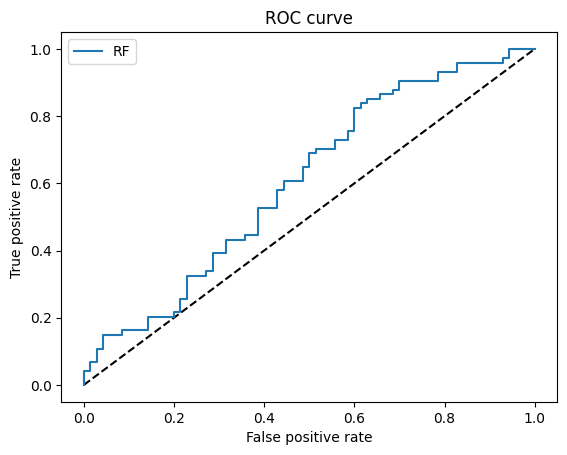

In [94]:
model.fit(X_train,y_train)
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, 
                            target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [95]:
# Get numerical feature importances
importances = list(model.best_estimator_.feature_importances_)
importances

[0.008326251528101531,
 0.011433208046098785,
 0.018507989881327232,
 0.22042348662297997,
 0.17791543824631162,
 0.19640713582759095,
 0.1790389457518549,
 0.18794754409573497]

In [101]:
all_returns_list = []

for trade_year in [2022, 2023]:
    start_year = trade_year - 10
    end_year = trade_year - 1


    for initial_date in initial_dates:

        initial_calendar_year = datetime.strptime(
            str(trade_year) + "-" + initial_date, "%Y-%m-%d")

        # Delay refers to how many days after the 1st or 15th we start the trade
        # This technically means we will never start a position on the 29-31st
        for delay in delay_range:
            start_calendar_year = initial_calendar_year + timedelta(days=delay)
            start_calendar = start_calendar_year.strftime('%m-%d')

            for hold_length in hold_range:
                end_calendar = (start_calendar_year + timedelta(days=hold_length)
                                ).strftime('%m-%d')
                stock_returns_list = []

                for stock in sub_stocks:
                    stock_returns_list.append(seasonal_return(sub_data, stock,
                                                              start_calendar, end_calendar, start_year, end_year))

                seasonal_returns = pd.concat(stock_returns_list)
                symbol_stats = seasonal_returns.groupby('Symbol').apply(
                    return_stats, risk_free_rate=0)
                symbol_stats['trade window'] = initial_calendar_year.strftime('%Y-%m-%d')
                symbol_stats['start date'] = start_calendar_year
                symbol_stats['end date'] = end_calendar
                symbol_stats['Sharpe Long'] = symbol_stats['avg r'] / symbol_stats['vol']
                symbol_stats['Sharpe Short'] = -symbol_stats['avg r'] / symbol_stats['vol']

                symbol_stats['hold length'] = hold_length
                all_returns_list.append(symbol_stats)

all_returns = pd.concat(all_returns_list)

# Annualize returns
all_returns['annualized r'] = (all_returns['avg r'] * 365 /
                               all_returns['hold length'])

In [102]:
all_returns['trade year']=all_returns['trade window'].str.slice(0,4)


In [107]:
all_returns.to_csv('seasonal_trades_2022_2023.csv')


In [33]:
later_returns = pd.read_csv('seasonal_trades_2022_2023.csv')

In [75]:
later_long_positions = later_returns[(later_returns['annualized r'] > 0.5) & 
(later_returns.up >= 6) & later_returns['avg r']>.01].sort_values(
    'Sharpe Long', ascending=False).groupby('trade window').head(10)

# Define the feature functions, keeping in mind that all_returns already has
# the seasonal data calculated

# Historical winrates
later_long_positions['past1yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-1,int(row['trade year'])-1), axis = 1)

later_long_positions['past3yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-3,int(row['trade year'])-1), axis = 1)

later_long_positions['past5yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-5,int(row['trade year'])-1), axis = 1)


In [76]:
later_long_positions['yesterday_ret'] = later_long_positions.apply(
    lambda row: get_recent_return(data_no_backfill, row['Symbol'],
                                  data.loc[row['start date']]['Price Date'],
                                  days_back=1), axis=1)


later_long_positions['ewm_vol'] = later_long_positions.apply(lambda row: get_ewm_vol(
    data, row['Symbol'], row['start date'], 30), axis = 1)

later_long_positions['long_momentum'] = later_long_positions.apply(lambda row:
    get_ewm_momentum(data, row['Symbol'], row['start date'],
        long_window = 10, short_window = 5), axis = 1)

later_long_positions['sp500_ewm_vol'] = later_long_positions.apply(lambda row: get_ewm_vol(
    spx, 'Adj Close', data.loc[row['start date']]['Price Date'],
    30), axis=1)

later_long_positions['sp500_ewma'] = later_long_positions.apply(lambda row:
                                                    get_ewm_momentum(spx, 'Adj Close',
                                                                     data.loc[row['start date']]['Price Date'],
                                                                     long_window=10, short_window=5), axis=1)

later_long_positions['sp500_yest_ret'] = later_long_positions.apply(lambda row:
                                                        get_recent_return(spx, 'Adj Close',
                                                                          data.loc[row['start date']]['Price Date'],
                                                                          days_back=1), axis=1)

later_long_positions['actual_return'] = later_long_positions.apply(lambda row:
    get_actual_return(data, row['Symbol'], row['start date'],
        str(row['trade year'])+'-'+row['end date']), axis = 1)


              precision    recall  f1-score   support

    no_trade       0.63      0.38      0.48       136
       trade       0.47      0.71      0.56       104

    accuracy                           0.53       240
   macro avg       0.55      0.55      0.52       240
weighted avg       0.56      0.53      0.52       240

                precision    recall  f1-score   support

no_trade_no_ML       0.00      0.00      0.00       136
   trade_no_ML       0.43      1.00      0.60       104

      accuracy                           0.43       240
     macro avg       0.22      0.50      0.30       240
  weighted avg       0.19      0.43      0.26       240



/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

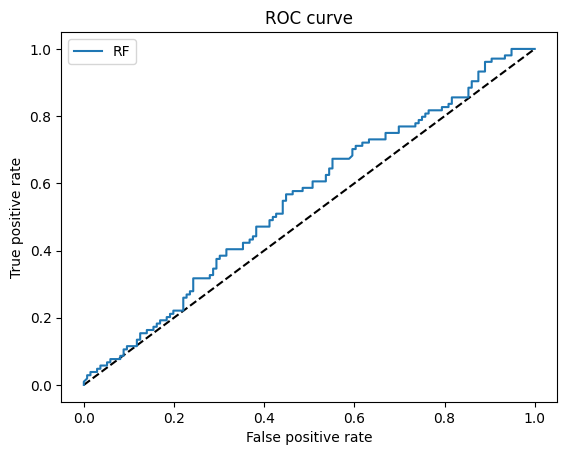

In [96]:
model.fit(X,y)

long_2022 = later_long_positions[later_long_positions['trade year']==2022]
X_2022 = long_2022[['past1yr','past3yr','past5yr','ewm_vol','long_momentum',
                   'yesterday_ret','sp500_ewma','sp500_yest_ret']].values
y_2022 = np.where(long_2022['actual_return'] > 0.01, 1, 0)

rf_trade_2022_prob = model.predict_proba(X_2022)[:, 1]
rf_trade_2022 = model.predict(X_2022)
fpr_rf, tpr_rf, _ = roc_curve(y_2022, rf_trade_2022_prob)
print(classification_report(y_2022, rf_trade_2022, 
                            target_names=['no_trade','trade']))

print(classification_report(y_2022,np.repeat(1,len(y_2022)),
                            target_names=['no_trade_no_ML','trade_no_ML']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

    no_trade       0.50      0.81      0.62       115
       trade       0.60      0.26      0.37       125

    accuracy                           0.53       240
   macro avg       0.55      0.54      0.49       240
weighted avg       0.55      0.53      0.49       240

                precision    recall  f1-score   support

no_trade_no_ML       0.00      0.00      0.00       115
   trade_no_ML       0.52      1.00      0.68       125

      accuracy                           0.52       240
     macro avg       0.26      0.50      0.34       240
  weighted avg       0.27      0.52      0.36       240



/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raywang/Desktop/finance/technical/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

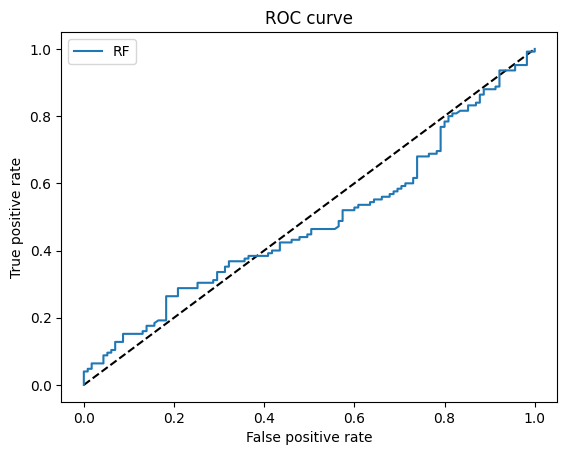

In [97]:
long_positions_to_2023 = pd.concat([long_positions, later_long_positions[later_long_positions['trade year']==2022]])
long_positions_to_2023['outcome'] = np.where(long_positions_to_2023['actual_return'] > 0.01, 1, 0)

X_to_2023 = long_positions_to_2023[['past1yr','past3yr','past5yr','ewm_vol','long_momentum',
                   'yesterday_ret','sp500_ewma','sp500_yest_ret']].values
y_to_2023 = long_positions_to_2023['outcome'].values

long_2023 = later_long_positions[later_long_positions['trade year']==2023]
X_2023 = long_2023[['past1yr','past3yr','past5yr','ewm_vol','long_momentum',
                   'yesterday_ret','sp500_ewma','sp500_yest_ret']].values
y_2023 = np.where(long_2023['actual_return'] > 0.01, 1, 0)

model.fit(X_to_2023,y_to_2023)

rf_trade_2023_prob = model.predict_proba(X_2023)[:, 1]
rf_trade_2023 = model.predict(X_2023)
fpr_rf, tpr_rf, _ = roc_curve(y_2023, rf_trade_2023_prob)
print(classification_report(y_2023, rf_trade_2023, 
                            target_names=['no_trade','trade']))

print(classification_report(y_2023,np.repeat(1,len(y_2023)),
                            target_names=['no_trade_no_ML','trade_no_ML']))


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [140]:
# How much money would we have made, though?
long_trade_outcomes_2022 = long_2022[(rf_trade_2022==1)]
long_trade_outcomes_2023 = long_2023[(rf_trade_2023==1)]

In [143]:
long_trade_outcomes_2022

,Symbol,N,avg r,vol,downside dev,upside dev,up,trade window,start date,end date,...,past1yr,past3yr,past5yr,yesterday_ret,ewm_vol,long_momentum,sp500_ewm_vol,sp500_ewma,sp500_yest_ret,actual_return
26741,TYL,10.0,0.042284,0.013003,0.000000,0.013003,10.0,2022-04-01,2022-04-11,04-25,...,1.0,1.000000,1.0,-0.028069,0.019854,-0.003896,0.012507,0.006273,-0.002655,-0.043702
46252,AMZN,10.0,0.074246,0.024286,0.000000,0.024286,10.0,2022-06-15,2022-06-25,07-23,...,1.0,1.000000,1.0,0.035128,0.029585,-0.006464,0.018692,-0.016602,0.030106,0.067614
46623,V,10.0,0.049820,0.017749,0.000000,0.017749,10.0,2022-06-15,2022-06-25,07-23,...,1.0,1.000000,1.0,0.044120,0.019656,-0.008219,0.018692,-0.016602,0.030106,0.051276
45180,MCO,10.0,0.043349,0.015764,0.000000,0.015764,10.0,2022-06-15,2022-06-20,07-18,...,1.0,1.000000,1.0,0.008753,0.020206,-0.028504,0.018142,-0.022297,0.002198,0.076908
38575,DXCM,10.0,0.152221,0.061494,0.000000,0.061494,10.0,2022-05-15,2022-05-25,06-22,...,1.0,1.000000,1.0,-0.117085,0.035845,-0.054884,0.017223,-0.019407,-0.008154,0.016779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17830,DLR,10.0,0.043814,0.047232,0.009500,0.034031,7.0,2022-03-01,2022-03-06,04-03,...,1.0,1.000000,0.8,0.014468,0.014883,-0.007730,0.012557,-0.008292,-0.007966,0.082862
69676,DUK,10.0,0.040870,0.046852,NaN,0.037813,9.0,2022-09-15,2022-09-25,10-23,...,1.0,1.000000,1.0,-0.009310,0.011572,-0.012486,0.014643,-0.018036,-0.017383,-0.128388
67665,MSI,10.0,0.013197,0.015200,0.005303,0.004697,8.0,2022-09-15,2022-09-20,09-27,...,1.0,1.000000,0.8,0.005711,0.012180,-0.005582,0.014925,-0.010680,0.006834,-0.059566
14388,EFX,10.0,0.023411,0.028347,0.005248,0.027126,8.0,2022-02-15,2022-02-25,03-04,...,1.0,0.666667,0.8,0.036601,0.019242,-0.024430,0.012196,-0.012737,0.014846,0.040837


In [215]:
# The main difference is that we take 55 trades a year vs. 240, with each trade
# generally having higher profitability. It makes sense to rescale our trade
# sizing to simulate one year of trading and cumulative returns between
# taking all of the technical trades vs. just the 
# I make two simplifying assumptions:
# 1) The trade returns are realized immediately rather than having to hold the
#    position to closure (up to three weeks), so that the money is available
#    for use in the next trading window (~every two weeks).
# 2) I assume we know "ahead of time" the number of trades we will make each
#    trade window, and divide the trade such that we end up using all of the
#    money per trade period
# The first assumption seems fairly innocuous since the assets are held for short
# periods and typically have movements in the single percents, i.e. the
# the amount of money risked due to drawdowns is minimal. In fact, if we removed
# the 3-week trades, we could make sure this holds since the position would be
# held for less than the time between trades.
# The second assumption is a bit trickier, since trades per window range from
# 1 to 10 in 2022, and 0 to 6 in 2023, but I want to abstract away from the
# bet sizing decision in this illustrative example. In reality I would have to
# predict the number of trades we would take each year to size the bets such
# that the portfolio is fully utilized.

# How much would taking all the long positions have made (10 trades per window)?
# To avoid the breakdown of logarithms as approximations to returns, calculate
# the per trade window new cash amount by averaging the 10 returns for that window
# Then take the cumulative product of all of these

long_2022_per_window_ret = long_2022.groupby('trade window')['actual_return'].mean().values
np.product(long_2022_per_window_ret+1) # Cumulative product, which is a 0.93% return
long_2022_ml_per_window_ret = long_trade_outcomes_2022.groupby('trade window')['actual_return'].mean().values
np.product(long_2022_ml_per_window_ret+1) # 23.1% return

# By comparison, the SP500 suffered a 20% loss from 01-03-2022 to 12-30-2022 (4796.56 to 3839.50)

# Now for 2023:
long_2023_per_window_ret = long_2023.groupby('trade window')['actual_return'].mean().values
np.product(long_2023_per_window_ret+1) # Cumulative product, which is a 45.9% return
long_2023_ml_per_window_ret = long_trade_outcomes_2023.groupby('trade window')['actual_return'].mean().values
np.product(long_2023_ml_per_window_ret+1) # 106.6% return

# By comparison, the SP500 would have a 24.7% return from 01-03-2023 to 12-29-2023 (3824.14 to 4769.83)
# If we account for a slippage/bid-ask spread of 1% per trade window, compared to 0% for a buy-and-hold
# SP500 trade, in 2022 we would have the following results
np.product(long_2022_per_window_ret+0.99) # 20.8% loss
np.product(long_2022_ml_per_window_ret+0.99) # 3.1% loss
np.product(long_2023_per_window_ret+0.99) # 15.1% return
np.product(long_2023_ml_per_window_ret+0.99) # 70.1% return

# So taking the simple technical position would have performed comparable/slightly worse than
# simply holding the SP500 once we account for the bid-ask spread/slippage per trade (saying nothing
# about taxes). But there is a real possibility of excess returns in both 2022/2023 with the seasonal
# strategy overlaid with a ML veto condition.

# Get max drawdown as function of array of returns (in order)
def max_drawdown(arr):
    drawdown = 0
    max_drawdown = 0
    for i in range(len(arr)):
        if arr[i] > 0:
            drawdown = 0
        else:
            drawdown += arr[i]
            if drawdown < max_drawdown:
                max_drawdown = drawdown
    return max_drawdown


# Sample SP500 semi-monthly (using trade windows, backfilled as necessary)
spx_bfill = spx.reindex(all_dates, method='bfill')
spx_bfill_vals_2022 = spx_bfill.loc[np.sort(long_2022['trade window'].unique())]
spx_bfill_rets_2022 = np.log(spx_bfill_vals_2022['Adj Close']/spx_bfill_vals_2022['Adj Close'].shift(1))
spx_bfill_vals_2023 = spx_bfill.loc[np.sort(long_2023['trade window'].unique())]
spx_bfill_rets_2023 = np.log(spx_bfill_vals_2023['Adj Close']/spx_bfill_vals_2023['Adj Close'].shift(1))

# Lastly, as a point of reference, the largest drawdowns for each strategy/year are given below
max_drawdown(long_2022_per_window_ret)
max_drawdown(long_2022_ml_per_window_ret)
max_drawdown(long_2023_per_window_ret)
max_drawdown(long_2023_ml_per_window_ret)
max_drawdown(spx_bfill_rets_2022)
max_drawdown(spx_bfill_rets_2023)

#      Long all  Long ML  SP500
# 2022 15.9%     9.6%     15.6%
# 2023 6.4%      4.3%     6.4%

array(['2022-04-01', '2022-06-15', '2022-02-01', '2022-05-15',
       '2022-06-01', '2022-03-01', '2022-10-15', '2022-07-15',
       '2022-11-01', '2022-07-01', '2022-10-01', '2022-11-15',
       '2022-01-15', '2022-01-01', '2022-05-01', '2022-03-15',
       '2022-12-15', '2022-08-15', '2022-04-15', '2022-09-15',
       '2022-09-01', '2022-08-01', '2022-12-01', '2022-02-15'],
      dtype=object)

In [231]:
model = 'n'

{'n_estimators': 50, 'max_samples': 0.3, 'max_features': 0.4, 'max_depth': 5}